# Esercizio 6.1 - 1D Ising Model

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import math
import scipy.stats
from itertools import cycle
import scipy
import subprocess
import os
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Funzione per sostituire righe in un file
def replace_line(file_name, line_num, text):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        
    lines[line_num] = text
    with open(file_name, 'w') as file:
        file.writelines(lines)

In [2]:
### Variabili per files e runs
CWD = os.getcwd()
tstep = 0.05
trange = np.arange(0.5, 2+tstep, tstep)
fnames = ['output.ene.0', 'output.heat.0', 'output.chi.0', 'output.mag.0'] # Nomi dei file di output

vten, vtheat, vtmag, vtchi = ([] for i in range(4))     # Vettori per le grandezze, Metropolis
vten1, vtheat1, vtmag1, vtchi1 = ([] for i in range(4)) # Vettori per le grandezze, Gibbs
vectornames = [[vten, vtheat, vtchi, vtmag],[vten1, vtheat1, vtmag1, vtchi1]]

vtenerr, vtheaterr, vtmagerr, vtchierr = ([] for i in range(4))     # Vettori per gli errori, Metropolis
vtenerr1, vtheaterr1, vtmagerr1, vtchierr1 = ([] for i in range(4)) # Vettori per gli errori, Gibbs
errnames = [[vtenerr, vtheaterr, vtchierr, vtmagerr],[vtenerr1, vtheaterr1, vtmagerr1, vtchierr1]]

Simulazione Monte Carlo di un modello di Ising 1D, compresa la stima di diverse grandezze termodinamiche con gli algoritmi di campionamento di Metropolis e di Gibbs. La simulazione consiste nel selezionare casualmente uno degli spin del reticolo unidimensionale e utilizzare uno dei due algoritmi per modificare il suo valore.

Nell'algoritmo di Metropolis si ha una probabilità di transizione $T\left(\nu|\mu\right)$ simmetrica, che seleziona lo spin $k$-esimo. A partire dalla vecchia configurazione $\mu$ il Metropolis genera una nuova configurazione $\nu$ e decide se invertire il valore dello spin calcolando $A$ e confrontandola con un numero random $r$ generato uniformemente tra 0 e 1:

$$A\left(\nu|\mu\right)=\min\left[1,\exp\left[-\beta\left(E_\nu-E_\mu\right)\right]\right]$$

con $E_\nu-E_\mu = 2Js_k^\mu\sum_{\text{i n.n. to k}} s_i^\mu + 2s_k^\mu h$. Il segno dello spin viene cambiato se $r<A\left(\nu|\mu\right)$ o lasciato invariato se $r>A\left(\nu|\mu\right)$.


Nell'algoritmo di Gibbs, invece, ogni mossa viene accettata. La probabilità di avere $s_k^\nu= \pm 1$ nella nuova configurazione, partendo dalla configurazione $\mu$ è

$$p\left(s_k^\nu=\pm1|\{s^\mu_j: j\neq k\}\right)= \frac{1}{1+\exp\left[\mp2\beta\left(J\sum_{\text{i n.n. to k}}s_i^\mu + h\right)\right]}.$$

La probabilità è confrontata dall'algoritmo con un numero casuale tra 0 e 1 per decidere se assegnare $+1$ o $-1$ allo spin.

Le grandezze di interesse sono derivate a partire dai valori di $H$, $\sum_{i=1,N}s_i$, $\left(\beta\sum_{i=1,N}s_i\right)^2$ e $H^2$. Per la stima delle prime 3 grandezze viene considerato un campo esterno nullo $h=0$:

$$\frac{U(N,T)}{N} = \frac{\langle H \rangle_{h=0}}{N}$$
$$\frac{C(N,T)}{N} = \frac{\beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)}{N}$$
$$\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$$



## ---------------------------------------------------- Simulazioni ----------------------------------------------------

Per calcolare energia interna per spin / capacità termica per spin / suscettività magnetica / magnetizzazione in funzione della temperatura, ho inserito nel codice la misura dei valori medi e delle incertezze di tali quantità. La temperatura viene fatta variare a ogni run del programma in piccoli step.

L'indice metro = 0 rappresenta le run svolte con l'algoritmo di Metropolis, mentre con metro = 1 viene usato il sampling di Gibbs. Il sistema viene inizialmente equilibrato e ogni run (ognuna a diversa T) parte dalla precedente, in quanto la differenza tra le T delle due run è minima ( $\Delta T = 0.02 $).

T varia nel range $\left[0.5;2.0\right]$ e il sistema è formato da $N = 50$ spins con $J = 1$.

In [3]:
############################ Metroindex = 0 --> Metropolis, = 1 --> Gibbs
for metroindex in range(2):
    print('Inizio metro = ',metroindex+1,'\n')
    # Elimino i file nella subdirectory Files e i file main.exe, *.o
    os.chdir("%s/Files" % CWD)
    subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
    subprocess.run("make cleanconf", shell=True, stdout=subprocess.PIPE)
    os.chdir(CWD)
    subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
    # Copio input iniziale in input.dat
    subprocess.run("make cpinput", shell=True, stdout=subprocess.PIPE)
    replace_line('input.dat', 4, "%s\n" % str(metroindex+1))
    # Equilibrazione
    print('Inizio equilibrazione')
    for count in range(3):
        os.chdir(CWD)
        subprocess.run("make esegui", shell=True)
        os.chdir("%s/Files" % CWD)
        subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
    print('Fine equilibrazione')
    print('Inizio runs a diverse T')
    ############################ Run a diverse T
    for t in trange:
        os.chdir("%s/Files" % CWD)
        subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
        os.chdir(CWD)
        subprocess.run("make esegui", shell=True)
        for i in range(3):
            filename1 = "%s/Files/%s" % (CWD, fnames[i])
            appo, appoerr = (np.genfromtxt(filename1, usecols=j+2, autostrip=True) for j in range(2))
            vectornames[metroindex][i].append(appo[-1])
            errnames[metroindex][i].append(appoerr[-1]) 
        replace_line('input.dat', 0, "%s\n" % str(format(t+tstep, '.2f')))
    print('Fine runs\n')    
  
    ############################ Run per la magnetizzazione
    subprocess.run("make cpinput", shell=True, stdout=subprocess.PIPE)
    replace_line('input.dat', 4, "%s\n" % str(metroindex+1))
    filename1 = "%s/Files/%s" % (CWD, fnames[3])
    replace_line('input.dat', 3, "%s\n" % str(0.02))

    # Equilibrazione
    print('Inizio equilibrazione')
    for count in range(3):
        os.chdir(CWD)
        subprocess.run("make esegui", shell=True)
        os.chdir("%s/Files" % CWD)
        subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
    print('Fine equilibrazione')
    print('Inizio runs per la magnetizzazione') 
    for t in trange:
        os.chdir("%s/Files" % CWD)
        subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
        os.chdir(CWD)
        subprocess.run("make esegui", shell=True)
        appo, appoerr = (np.genfromtxt(filename1, usecols=j+2, autostrip=True) for j in range(2))
        vectornames[metroindex][3].append(appo[-1])
        errnames[metroindex][3].append(appoerr[-1])
        replace_line('input.dat', 0, "%s\n" % str(format(t+tstep, '.2f')))
    print('Fine')
    print('\n')

Inizio metro =  1 

Inizio equilibrazione
Fine equilibrazione
Inizio runs a diverse T
Fine runs

Inizio equilibrazione
Fine equilibrazione
Inizio runs per la magnetizzazione
Fine


Inizio metro =  2 

Inizio equilibrazione
Fine equilibrazione
Inizio runs a diverse T
Fine runs

Inizio equilibrazione
Fine equilibrazione
Inizio runs per la magnetizzazione
Fine




## ------------------------------------------------------ Grafici ------------------------------------------------------

Sono mostrati i grafici di $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ e le loro incertezze, ottenuti per entrambi gli algoritmi con $N = 20$ blocchi ciascuno di $M = 10^5$ Monte Carlo step. Nei grafici sono riportati anche gli andamenti delle funzioni teoriche esatte; i valori di energia interna per spin, capacità termica per spin e suscettività magnetica seguono con precisione la teoria. Tuttavia le barre d'errore non sempre vanno a intersecare le curve dei valori attesi.

Il calcolo della magnetizzazione è stato eseguito a parte, ponendo il campo esterno a $h=0.02$ (con $h=0$ si ha magnetizzazione nulla, dato che $\langle \sum_{i=1,N}s_i \rangle_{h=0} =0$):

$$M(N,T,h=0.02)= \left\langle \sum_{i=1,N}s_i \right\rangle_{h=0.02}$$

Anche per $M$ si ottiene un buonissimo accordo col valore teorico.

In [4]:
# Variabili teoriche
T = np.linspace(0.4,2.2,num=100)
b = 1/T
J, Ns = 1.0, 50
th = np.tanh(J/T)
thN = th**Ns
ch = 1/th
E = -J*( th + ch*thN )/( 1 + thN )
Heat = ((b*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
h = 0.02 # External field
l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
X = b*np.exp(2*b*J)*(1-thN)/(1+thN)

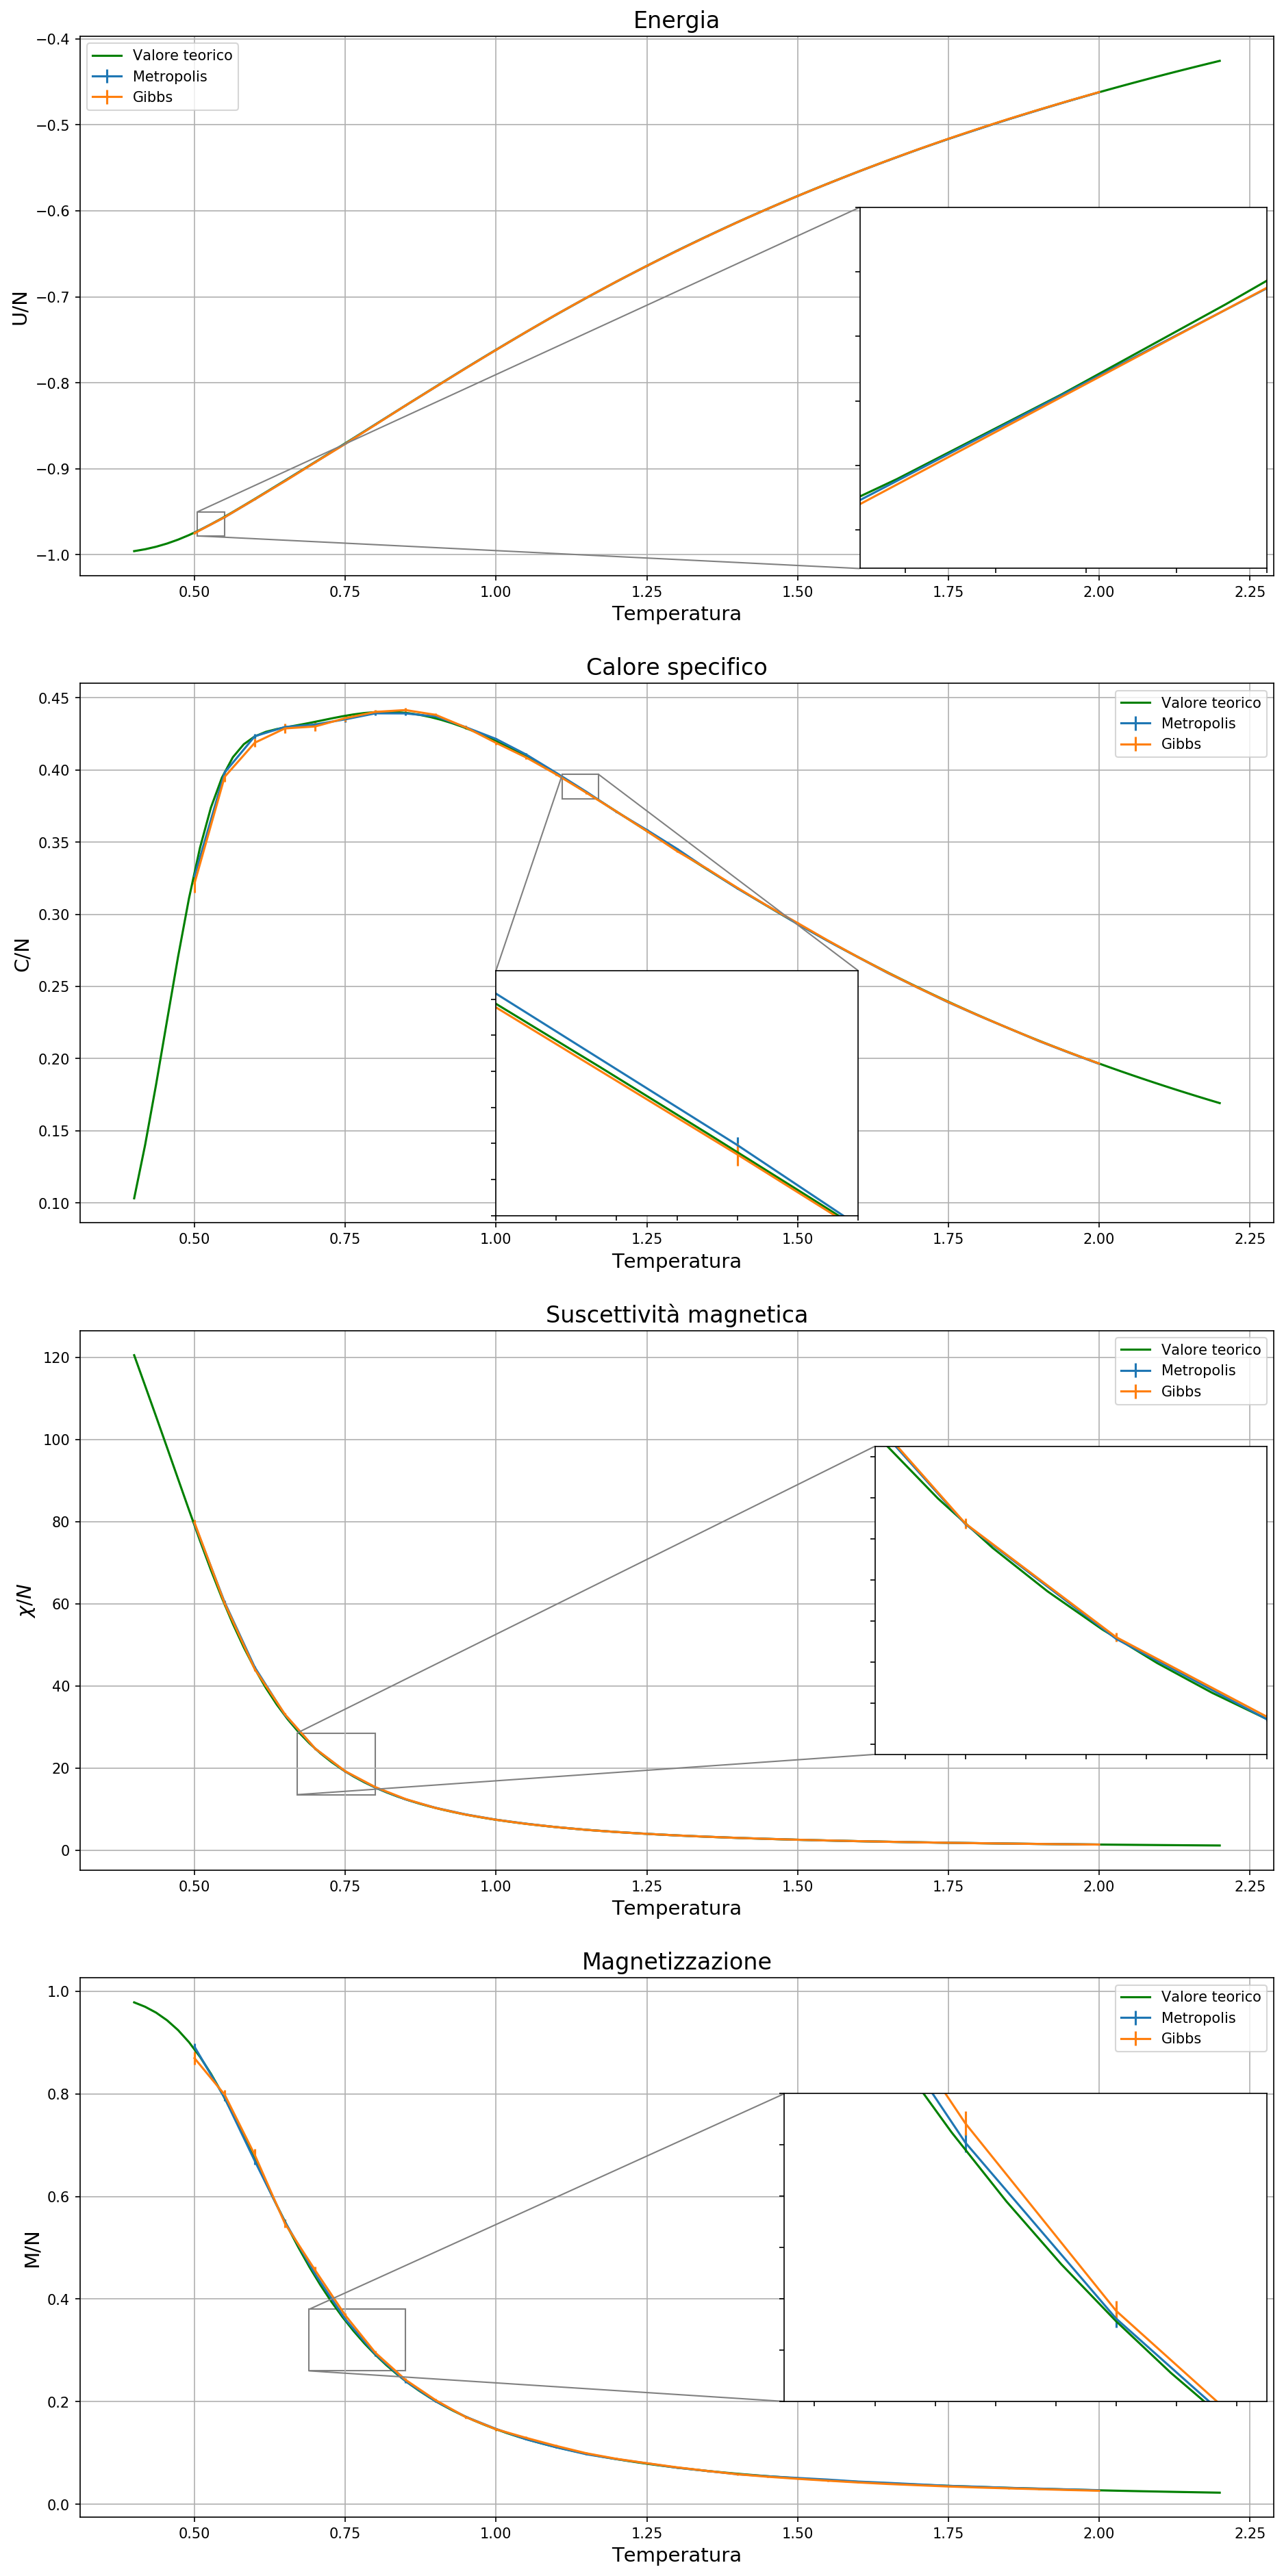

In [5]:
# Grafici
fig = plt.figure(figsize=(15, 32) , dpi=150)
gnames = ['Energia','Calore specifico','Suscettività magnetica','Magnetizzazione'] # Nomi grafici
labnames = ['U/N', 'C/N', r'$\chi /N$', 'M/N'] # Labels asse y
thvalues = [E, Heat, X, M] # Funzioni teoriche
xlimits = [[0.505,0.55], [1.11,1.17], [0.67,0.80], [0.69,0.85] ] # Limiti sulla x per zoom
ylimits = [[-0.978,-0.95], [0.380,0.397], [13.5,28.5], [0.26,0.38] ] # Limiti sulla y per zoom
zoomval = [15,10,5,5] # Valore dello zoom
locval = [4,8,7,7] # Posizione zoomed inset

for i in range(4):
    ax = fig.add_subplot(4, 1, i+1)
    x1, x2 = xlimits[i][0], xlimits[i][1]    # Zoom del grafico
    y1, y2 = ylimits[i][0], ylimits[i][1]
    axins = zoomed_inset_axes(ax, zoomval[i], loc=locval[i])
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    if i==1:    # Posizione dello zoom
        mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")
    elif i==2:
        mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
    else:
        mark_inset(ax, axins, loc1=3, loc2=2, fc="none", ec="0.5")
    # Generazione grafici su subplot "ax" e zoomed inset "axins"
    ax.errorbar(trange, vectornames[0][i], yerr = errnames[0][i], label = 'Metropolis')
    ax.errorbar(trange, vectornames[1][i], yerr = errnames[1][i], label = 'Gibbs')
    ax.plot(T, thvalues[i],c='g', label='Valore teorico')   
    axins.errorbar(trange, vectornames[0][i], yerr = errnames[0][i])
    axins.errorbar(trange, vectornames[1][i], yerr = errnames[1][i])
    axins.plot(T, thvalues[i],c='g')
    axins.grid(False)
    ax.set_xlabel('Temperatura', fontsize=14)
    ax.set_ylabel(labnames[i], fontsize=14)
    ax.set_title(gnames[i], fontsize=16)
    ax.grid(True)
    ax.legend(loc=0)
    
plt.show()